# IDA - Customer Churn Prediction

#### This dataset contains 7043 observations (i.e. customers) and 21 features that can be broken down into three categories:
    1) Demographics
    2) Account information
    3) Payment information.
#### Our target feature is the “Churn” column, which indicates whether a customer has terminated service (“churned customer”) or is still with the company (“existing customer”).

In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as sci
from collections import OrderedDict
import warnings
warnings.filterwarnings='ignore'

In [2]:
#Loading data
df=pd.read_csv("TelcoCustomerChurn.csv")
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,CLTV,Churn Reason,Churn Value
0,5196-WPYOW,1.0,United States,California,Paso Robles,93446.0,"35.634222, -120.728341",35.634222,-120.728341,Male,...,No,No,One year,No,Mailed check,60.05,3994.05,6148.0,NaN,0.0
1,8189-HBVRW,1.0,United States,California,Los Angeles,90005.0,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,Month-to-month,No,Electronic check,90.80,4921.2,5249.0,NaN,0.0
2,4091-TVOCN,1.0,United States,California,Potrero,91963.0,"32.619465, -116.593605",32.619465,-116.593605,Male,...,Yes,Yes,One year,Yes,Credit card (automatic),78.75,3682.45,2257.0,NaN,0.0
3,9603-OAIHC,1.0,United States,California,Palmdale,93551.0,"34.613476, -118.256358",34.613476,-118.256358,Male,...,No,No,Month-to-month,Yes,Electronic check,70.05,70.05,2469.0,NaN,0.0
4,8647-SDTWQ,1.0,United States,California,Hood,95639.0,"38.375325, -121.507935",38.375325,-121.507935,Male,...,No,No,Month-to-month,Yes,Electronic check,74.30,4018.35,4133.0,NaN,0.0


In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
print("Number of rows: {0}, number of columns: {1}".format(df.shape[0], df.shape[1]))

Number of rows: 4718, number of columns: 31


In [5]:
#Handling data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4718 entries, 0 to 4717
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         4687 non-null   object 
 1   Count              4691 non-null   float64
 2   Country            4708 non-null   object 
 3   State              4715 non-null   object 
 4   City               4688 non-null   object 
 5   Zip Code           4698 non-null   float64
 6   Lat Long           4713 non-null   object 
 7   Latitude           4695 non-null   float64
 8   Longitude          4685 non-null   float64
 9   Gender             4698 non-null   object 
 10  Senior Citizen     4711 non-null   object 
 11  Partner            4678 non-null   object 
 12  Dependents         4672 non-null   object 
 13  Tenure Months      4704 non-null   float64
 14  Phone Service      4692 non-null   object 
 15  Multiple Lines     4696 non-null   object 
 16  Internet Service   4692 

## Handling null values

In [72]:
df.replace(" ",np.nan,inplace=True,regex=True)

In [7]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'],errors="coerce")

## Numerical Statistics

In [8]:
stat_num_df=df.loc[:,['Tenure Months','Monthly Charges','Total Charges','CLTV']]

In [9]:
def custom_summary(data):
    result=[] # This is an empty list to store the iterated result of stats
    for col in data.columns:
        if data[col].dtype!= 'O' and 'str':
            stats=OrderedDict({'Feature_name':col,
                               'Count':data[col].count(),
                               'Minimum':round(data[col].min(),2),
                               'Quartile 1':round(data[col].quantile(0.25),2),
                               'Mean':round(data[col].mean(),2),
                               #'Median':round(data[col].median(),2),
                               'Mode':round(data[col].mode(),2),
                               'Quartile 3':round(data[col].quantile(0.75),2),
                               'IQR':round(data[col].quantile(0.75),2)-round(data[col].quantile(0.25),2),
                               'Maximum':round(data[col].max(),2),
                               'Variance':round(data[col].var(),2),
                               'SD':round(data[col].std(),2),
                               'Kurtosis':round(data[col].kurt(),0),
                               'Skewness':round(data[col].skew(),2)
                               
                              })
            result.append(stats)
                        
#     # Skewness comments
    
    
            if stats['Skewness'] < -1:
                skewtype='Highly Negatively Skewed'
            elif -1<stats['Skewness']<-0.5:
                skewtype='Moderately Negatively Skewed'
            elif -0.5<stats['Skewness']<0:
                skewtype="Fairly symmetric but Negative"
            elif 0<stats['Skewness']<0.5:
                skewtype="Fairly Symmetric but positive"
            elif 0.5<stats['Skewness']<1:
                skewtype='Moderately Positively Skewed'
            elif stats['Skewness']>1:
                skewtype='Highly Positively Skewed'
            else:
                skewtype='Error'
            stats['Skewtype']=skewtype
    
#     #Outlier comments ---||An outlier is a data point that lies outside the overall pattern in a distribution||---
    
            up=stats['Quartile 3']+1.5*stats['IQR']
            low=stats['Quartile 1']-1.5*stats['IQR']
            if len([x for x in data[col] if x < low or x > up]) > 0:
                outlier_comment='Has Outliers'
            else:
                outlier_comment='Has No Outliers'
            stats['Outlier_Comments']=outlier_comment
    
#     #Condition to type of Kurtosis
        
            if stats['Kurtosis']==0:
                Kurtype='Mesokurtic'
            elif stats['Kurtosis']>0:
                Kurtype='Leptokurtic'
            else:
                Kurtype='Platikurtic'
            stats['Kurtype']=Kurtype
            
              
       
    result_df=pd.DataFrame(data=result)
    return result_df

In [10]:
custom_summary(stat_num_df).T

,0,1,2,3
Feature_name,Tenure Months,Monthly Charges,Total Charges,CLTV
Count,4704,4714,4695,4692
Minimum,0.0,18.25,18.85,2003.0
Quartile 1,9.0,35.46,412.33,3477.5
Mean,32.73,64.89,2311.05,4406.63
Mode,0 1.0 dtype: float64,0 20.05 dtype: float64,0 19.75 1 20.20 dtype: float64,0 2269.0 1 5096.0 dtype: float64
Quartile 3,56.0,89.95,3877.08,5402.25
IQR,47.0,54.49,3464.75,1924.75
Maximum,72.0,118.75,8684.8,6499.0
Variance,605.41,908.47,5203547.91,1410553.45


### Revenue sources

In [11]:
revenue_services = []
revenue_services_labels = []

# Phone service only customers
revenue_services.append(df[(df["Internet Service"] == "No") & (df["Phone Service"] == "Yes")]["Total Charges"].sum())
revenue_services_labels.append("Phone Only")

# Internet service only customers
revenue_services.append(df[(df["Internet Service"] != "No") & (df["Phone Service"] == "No")]["Total Charges"].sum())
revenue_services_labels.append("Internet Only")

# Phone  and Internet customers
revenue_services.append(df[(df["Internet Service"] != "No") & (df["Phone Service"] == "Yes")]["Total Charges"].sum())
revenue_services_labels.append("Phone and Internet")

In [12]:
def make_pie_chart(data, labels, title, font_size=10, fig_sizes=[6.0, 4.0]):
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams.update({'figure.figsize': fig_sizes})
    
    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.pie(data, labels=labels, startangle=90, autopct='%1.1f%%')
    ax.set_title(title)
    plt.show()
    return None

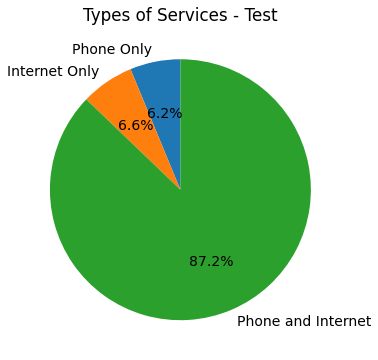

In [13]:
make_pie_chart(revenue_services, revenue_services_labels, "Types of Services - Test", 14, [10, 6])

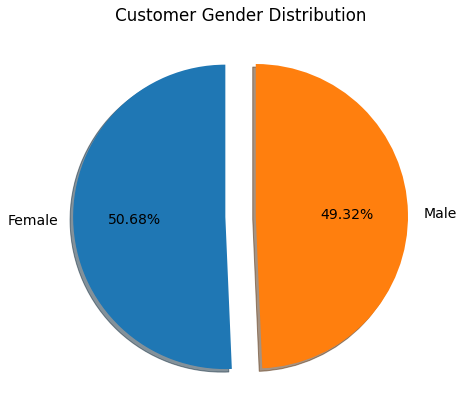

In [22]:
# Creating plots
df['Gender']=df['Gender'].astype('category')
fig = plt.figure(figsize =(10, 7))
plt.pie(df["Gender"].value_counts(), labels = df.Gender.cat.categories, startangle=90,explode=(0.1, 0.1),shadow=True,autopct='%1.2f%%')
plt.title('Customer Gender Distribution')
plt.show()

## Churning effect because of monthly charges

In [15]:
monthly_charges_churned = []
monthly_charges_current = []
years = [1, 2, 3, 4, 5, 6]
for i in years:
    start_month = (i - 1) * 12
    end_month = i * 12
    monthly_charges_churned.append(df[(df["Internet Service"] != "No") & (df["Phone Service"] == "Yes") & (df["Churn Value"] == "Yes") & (df["Tenure Months"] >= start_month) & (df["Tenure Months"] < end_month)]["Monthly Charges"].median())
    monthly_charges_current.append(df[(df["Internet Service"] != "No") & (df["Phone Service"] == "Yes") & (df["Churn Value"] == "No") & (df["Tenure Months"] >= start_month) & (df["Tenure Months"] < end_month)]["Monthly Charges"].median())

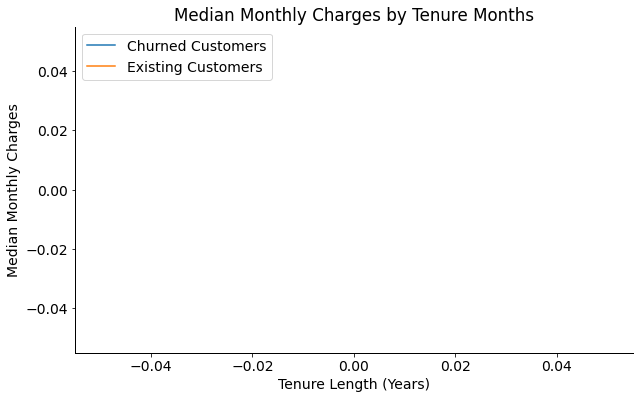

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(years, monthly_charges_churned, label="Churned Customers")
ax.plot(years, monthly_charges_current, label="Existing Customers")
ax.set_title("Median Monthly Charges by Tenure Months")
ax.set_xlabel("Tenure Length (Years)")
ax.set_ylabel("Median Monthly Charges")
ax.legend(loc="upper left")

cur_axes = plt.gca()
cur_axes.spines['top'].set_visible(False)
cur_axes.spines['right'].set_visible(False)
cur_axes.spines['bottom'].set_linewidth(1.0)
cur_axes.spines['left'].set_linewidth(1.0)

plt.show()

In [18]:
import geopandas as gpd
import plotly.express as px
import descartes
from shapely.geometry import Point, Polygon

In [19]:
geometry=[Point(xy) for xy in zip(df["Longitude"],df["Latitude"])]
crs={'init':'epsg:4326'}

In [20]:
geo_df=gpd.GeoDataFrame(df,crs=crs,geometry=geometry)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


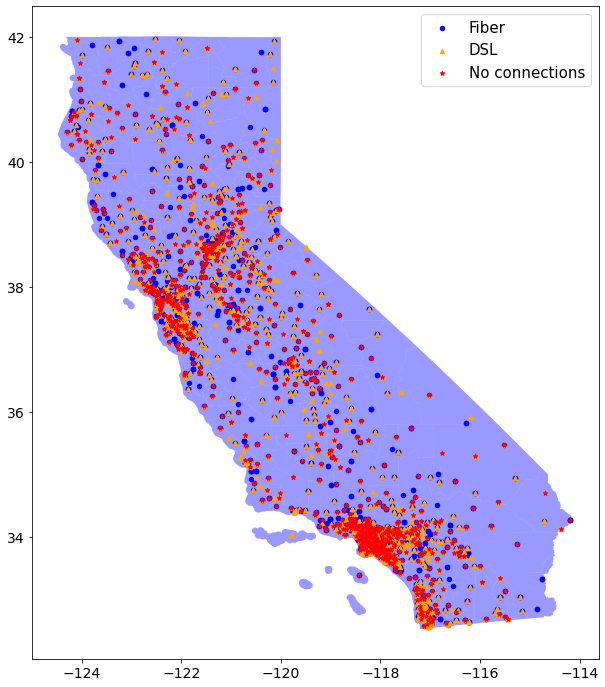

In [21]:
street_map=gpd.read_file('C:/Users/USER/ML Working/Cutomer Churn Project/tl_2016_06_cousub.shp')
fig,ax=plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.4, color="blue")
geo_df[geo_df['Internet Service']=="Fiber optic"].plot(ax=ax,markersize=20,color="blue",marker="o",label="Fiber")
geo_df[geo_df['Internet Service']=="DSL"].plot(ax=ax,markersize=20,color="orange",marker="^",label="DSL")
geo_df[geo_df['Internet Service']=="No"].plot(ax=ax,markersize=20,color="red",marker="*",label="No connections")
ax.legend(prop={'size': 15})

## Customer Lifespan

In [77]:
df_clean = df.replace(r'^\s*$', np.nan, regex=True)
def display_percent(plot, feature, total):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 10, ha="center")
    plt.show()

C:\Users\USER\AppData\Local\Temp/ipykernel_8028/3818959526.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  percentage = '{:.1f}%'.format(100 * p.get_height() / total)


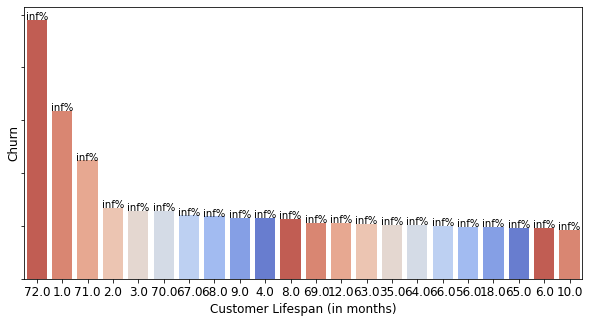

In [78]:
p = sns.color_palette("coolwarm", 10)
p.reverse()

df_top_churn = pd.DataFrame(df_clean[df_clean['Churn Value'] == 0.00 ]['Tenure Months'].value_counts().sort_values(ascending=False))
total_churn = df_clean[df_clean['Churn Value'] == 'Yes'].shape[0]

fig, ax = plt.subplots(figsize=(10,5))
sns_lifespan = sns.barplot( x = df_top_churn[:10].index, y = df_top_churn[:10]["Tenure Months"], ax=ax, palette=p, order=df_top_churn[:10].index)
plt.xticks(size=12)
plt.xlabel('Customer Lifespan (in months)', size=12)
plt.yticks(size=12)
plt.ylabel('Churn', size=12)
plt.tick_params(labelleft=False)

display_percent(ax, df_top_churn, total_churn)